In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
	_genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
	O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [6]:
def get_parameters(mean, cov):
	mu = np.log(mean) #- (np.log(cov**2 + 1) / 2)
	alpha = np.sqrt(np.log(cov**2 + 1)) / np.log(mean)
	sigma = alpha * np.log(mean)
	return mu, sigma

def get_distributions(mean_p, mean_r, cov,
					  size=100000):
	rng = np.random.default_rng()

	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r, sigma_r = get_parameters(mean_r, cov)

	dist_p = np.exp(np.random.normal(mu_p, sigma_p, size))
	dist_r = np.exp(np.random.normal(mu_r, sigma_r, size))
	return dist_p, dist_r

In [7]:
mean_p = 5000
mean_r = 100

dist_p, dist_r = get_distributions(mean_p, mean_r, 0.2)
dist_p_high, dist_r_high = get_distributions(mean_p, mean_r, 2)
dist_p_very_high, dist_r_very_high = get_distributions(mean_p, mean_r, 100)

In [8]:
np.std(dist_p) / np.mean(dist_p)

0.20002703247310152

In [9]:
np.std(dist_p_high) / np.mean(dist_p_high)

1.9620098738616463

In [10]:
np.std(dist_p_very_high) / np.mean(dist_p_very_high)

31.43442412146642

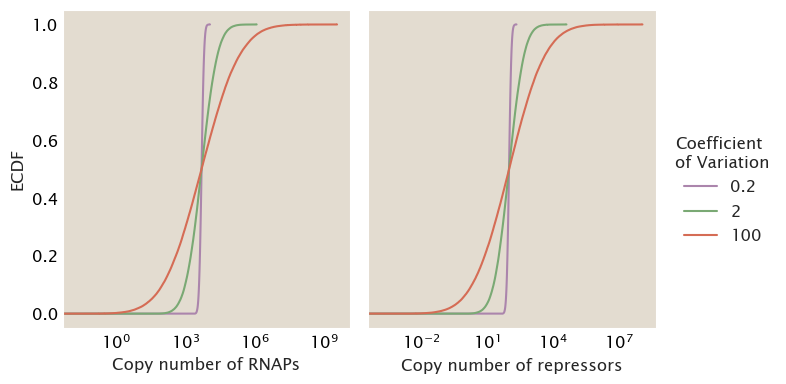

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax1, ax2 = axes
sns.ecdfplot(dist_p, ax=ax1, label='0.2', color='#AB85AC')
sns.ecdfplot(dist_p_high, ax=ax1, label='2', color='#7AA974')
sns.ecdfplot(dist_p_very_high, ax=ax1, label='100', color='#D56C55')
ax1.set_xlabel('Copy number of RNAPs')
ax1.set_ylabel('ECDF')
ax1.set_xscale('log')

sns.ecdfplot(dist_r, ax=ax2, label='0.2', color='#AB85AC')
sns.ecdfplot(dist_r_high, ax=ax2, label='2', color='#7AA974')
sns.ecdfplot(dist_r_very_high, ax=ax2, label='100', color='#D56C55')
ax2.set_xlabel('Copy number of repressors')
ax2.set_xscale('log')
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1.45, 0.65), frameon=False,
		   title='Coefficient\nof Variation')

# Setting custom ticks for log scale
#tick_positions = [10**1, 10**3, 10**5]
#tick_labels = ['$10^1$', '$10^3$', '$10^5$']
#ax2.set_xticks(tick_positions)
#ax2.set_xticklabels(tick_labels)

ax1.set_ylim(-0.05, 1.05)

plt.tight_layout()
#plt.savefig('../rebuttal_plots/figR5.pdf')

In [12]:
def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
							 p_emat, r_emat, ep_wt, er_wt,
							 mean_p, mean_r, cov):
	rng = np.random.default_rng()
	
	mu_p, sigma_p = get_parameters(mean_p, cov)
	mu_r, sigma_r = get_parameters(mean_r, cov)

	n_p = rng.lognormal(mu_p, sigma_p, 1)[0]
	n_r = rng.lognormal(mu_r, sigma_r, 1)[0]
	
	w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
	w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

	z = np.zeros(3)
	z[0] = 1
	z[1] = n_p / n_NS * w_p
	z[2] = n_r / n_NS * w_r

	return z[1] / np.sum(z)

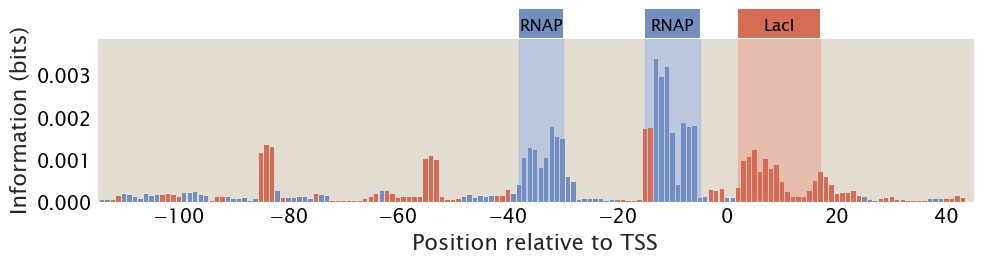

In [13]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 5000
mean_r = 10
cov = 100

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
						*[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
						  mean_p, mean_r, cov])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
							   annotate_stn=False)